[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1nC3zMTRjp5UztroJXmz7ILcctviRdVJy)
# Deep Learning Homework - Group Zerocool

## Team Members
- **Néder Brúnó** (Neptun Code: NQKZUX)
- **Jenei Ákos** (Neptun Code: EBBUE7)
- **Tasi Gergő** (Neptun Code: BRY27P)


## Project Overview
Our project aims to create a **Convolutional Neural Network (CNN)** that can identify skin cancer in patients using images of affected areas. We will utilize the **ISIC 2024 Challenge** dataset, provided by Kaggle, which contains a wide range of dermoscopic images for skin cancer diagnosis.

For more information about the dataset, you can visit the competition page on Kaggle: [ISIC 2024 Challenge](https://www.kaggle.com/competitions/isic-2024-challenge).

---

### For the first milestone of this project, we will be:

- Downloading and importing the database.

- Removing the incomplete or unneccessary parts of the metadata provided.

- Shrinking the database, due to the small amount of positive cases compared to the negative ones.

- Loading in the images from the disk.

- Splitting the metadata and the images into Train, Validation and Test sets.

---

### For the second milestone of this project, we will be:

- Improving the way data is handled.

- Creating the base models for the project.

- Running and testing the models.

- Balancing the Positive to Negative data ratio.



In [ ]:
#install all the required packages
%pip install numpy matplotlib opencv-python rarfile tensorflow pandas scikit-learn requests patool seaborn

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
import requests

Below are variables to easily control the models and other data in the Notebook.

In [6]:
folder_path = "data/train-image/image"  #Folder where the training images are stored
sheet_path = "data/train-metadata.csv"  #Folder where the training sheet is stored
download_data = False                   #True/False depending on whether you wish to download the dataset or not

images_to_load = 5000                   #Amount of non cancerous images to load along with all the 393 cancerous pictures
duplicate_cancerous_imgs = True         #True/False depending on wheter you wish to augment and duplicate the cancerous images 
duplicate_non_cancerous_imgs = False    #True/False depending on wheter you wish to augment and duplicate the non cancerous images 
duplicate_imgs_number = 7               #Amount of duplicate images to create

model1_epochs = 50                      #Number of epochs to run the CNN model for
model2_epochs = 300                     #Number of epochs to run the Fully Connected model for

In [4]:
#Downloading the database next to the notebook (credits to Kaggle: https://www.kaggle.com/competitions/isic-2024-challenge)
if download_data:
    response = requests.get("https://dl.dropboxusercontent.com/scl/fi/druub1bxwxl5wjkwndg8c/data.zip?rlkey=bcveewvfp9hvpkz99z04n97et&st=dpqdbvl2&dl=0")
    with open('data.zip', 'wb') as file:
        file.write(response.content)

In [5]:
#Unzip the downloaded data into a folder next to the notebook
if download_data:
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

---

### We have made some changes to the database's metadata outside of the code:

- We removed collumns which's data we deemed unneccessary or that which would've ruined the learning capability of the model.

- In the age collumn there was incomplete data. We replaced the empty spaces with the average age of the patients. (58)

- Changed the raw text type of the photo's location to a one-hot-coded style, with 8 new collumns.


In [6]:
#Read in the entire raw database using panda
X_metadata = pd.read_csv(sheet_path)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Separate the cancerous and non cancerous photos, so we can prune the data,
#as 400k+ negative and 393 positive cases is not a good ratio to teach the model with.
X_metadata_cancer =  X_metadata[X_metadata["target"] != 0]
X_metadata_notcancer = X_metadata[X_metadata["target"] != 1]

#Select the first 'images_to_load' elements in the not cancerous pictures
#This number can be changed in the import section to fine-tune learning.
X_metadata = X_metadata_notcancer[:images_to_load]

#And then merge it together with the 393 cancerous pictures
X_metadata = pd.concat([X_metadata, X_metadata_cancer])

print(X_metadata.shape)

#Split off the ID and Target section to a different dataframe (Y)
features = ["isic_id", "target"]
Y_metadata = X_metadata.filter(features)

#Split off only the target field of the database (Y)
Y_target = X_metadata.filter(['target'])

#Delete the target collumn from the X dataframe
X_metadata = X_metadata.drop(columns=["target"])

(5393, 45)


In [7]:
#We use Min-Max scaling to increase the learning accuracy of the model

#Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Select only the numerical columns to scale
numerical_cols = X_metadata.select_dtypes(include=['float64', 'int64']).columns

#Scale the numerical columns using apply
X_metadata[numerical_cols] = X_metadata[numerical_cols].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
print(X_metadata[:4])

        isic_id  age_approx  clin_size_long_diam_mm  tbp_lv_A  tbp_lv_Aext  \
0  ISIC_0015670    0.642857                0.093290  0.379483     0.448177   
1  ISIC_0015845    0.642857                0.004136  0.664434     0.704390   
2  ISIC_0015864    0.642857                0.109835  0.437412     0.472557   
3  ISIC_0015902    0.714286                0.101563  0.230348     0.332853   

   tbp_lv_B  tbp_lv_Bext  tbp_lv_C  tbp_lv_Cext  tbp_lv_H  tbp_lv_Hext  \
0  0.517613     0.375848  0.514322     0.439011  0.713104     0.415154   
1  0.504884     0.393312  0.663542     0.604710  0.505537     0.204435   
2  0.755377     0.655815  0.722084     0.665091  0.809574     0.541977   
3  0.399800     0.292614  0.357099     0.319450  0.765259     0.490943   

   tbp_lv_L  tbp_lv_Lext  tbp_lv_areaMM2  tbp_lv_area_perim_ratio  \
0  0.709664     0.641798        0.014286                 0.420955   
1  0.628616     0.545214        0.001504                 0.028357   
2  0.703684     0.636650       

In [8]:
#We will use 20% of the data to Validate the model and 20% to Test the model.

#Split main dataset into train and test batches.
X_train, X_test, Y_train, Y_test = train_test_split(X_metadata, Y_metadata, test_size=0.2, shuffle=True, random_state=2)

#Split training dataset into train and validation batches
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2/0.8, random_state=3)# 0.2/0.8 x 0.8 = 0.2

print("X shape:")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(" ")
print("Y shape:")
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
print(" ")
print("first element:")
print(" ")
print(X_train.iloc[0])
print(" ")
print(Y_train.iloc[0])

X shape:
(3235, 44)
(1079, 44)
(1079, 44)
 
Y shape:
(3235, 2)
(1079, 2)
(1079, 2)
 
first element:
 
isic_id                         ISIC_0121788
age_approx                          0.714286
clin_size_long_diam_mm              0.152574
tbp_lv_A                            0.416946
tbp_lv_Aext                         0.543325
tbp_lv_B                            0.426485
tbp_lv_Bext                         0.484082
tbp_lv_C                            0.469687
tbp_lv_Cext                         0.568384
tbp_lv_H                            0.606612
tbp_lv_Hext                         0.393138
tbp_lv_L                            0.585672
tbp_lv_Lext                         0.708154
tbp_lv_areaMM2                      0.058324
tbp_lv_area_perim_ratio             0.078411
tbp_lv_color_std_mean               0.216348
tbp_lv_deltaA                       0.284889
tbp_lv_deltaB                       0.378561
tbp_lv_deltaL                       0.500011
tbp_lv_deltaLB                      0.51168

In [9]:
#Function to add  a tiny bit of noise to the augmented images
#Usefull so we can duplicate more images without the model learning the exact images
def add_noise(img):
    noise = np.random.normal(loc=0.0, scale=0.01, size=img.shape)
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0.0, 1.0)  # Ensure pixel values are valid
    return img_noisy


#Augmentation function that applies transformations and yields multiple augmented images
def augment_image(image, num_augmented_versions=duplicate_imgs_number):
    data_gen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=add_noise  #Apply the noise function
    )
    
    #Expand dimensions to match the expected input shape
    image = np.expand_dims(image, axis=0)
    
    #Generate augmented images
    for _ in range(num_augmented_versions):
        augmented_image = next(data_gen.flow(image, batch_size=1))[0]
        yield augmented_image


#Function to load and preprocess images with the given name
def preprocess_image(image_name):
    image_path = os.path.join(folder_path, image_name + ".jpg")

    img = cv2.imread(image_path)

    if img is None:
        raise FileNotFoundError(f"Image {image_name} not found in folder.")

    #The images are random sizes, but around 125x125, so we resize them all to be 125x125
    img = cv2.resize(img, (125, 125))
    
    #We normalize the images, so the model's learning accuracy improves
    img = img / 255.0
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                
    return img

#Function to turn images loaded with OpenCV into numpy arrays
def image_to_array(img):
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  #Add batch dimension
    return img_array  

#Image loading function with generation of multiple augmented images
def data_generator(Y_metadata):
    for idx, image_name in enumerate(Y_metadata.iloc[:, 0]):  # Access the first column
        try:
            #Load and resize the image
            img = preprocess_image(image_name)

            #Yield the original image first
            yield img, Y_metadata['target'].iloc[idx]

            #If augmentation is enabled and the image is cancerous (or non cancerous image duplication is enabled)
            #Generate and yield multiple augmented versions
            if (Y_metadata['target'].iloc[idx] == 1 and duplicate_cancerous_imgs) or (duplicate_non_cancerous_imgs and Y_metadata['target'].iloc[idx] == 0):
                for augmented_img in augment_image(img):
                    yield augmented_img, Y_metadata['target'].iloc[idx]

        except FileNotFoundError:
            print(f"Image {image_name} not found in folder.")

#Create the image datasets for train-validation-test sets with tensorflows Dataset generator
def create_dataset(metadata):
    return tf.data.Dataset.from_generator(
        lambda: data_generator(metadata),
        output_signature=(
            tf.TensorSpec(shape=(125, 125, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

#Create the train, validation, and test sets with augmentation, in batches of 32.
train_images = create_dataset(Y_train).shuffle(10000).batch(32)  
validation_images = create_dataset(Y_val).shuffle(10000).batch(32)  
test_images = create_dataset(Y_test).shuffle(10000).batch(32)  

In [10]:
num_train_images_positive = sum(1 for image, label in train_images.unbatch() if label == 1)
num_train_images_negative = sum(1 for image, label in train_images.unbatch() if label == 0)
print("Amount of non cancerous images in training pile:", num_train_images_negative)
print("Amount of cancerous images in training pile:", num_train_images_positive)

Amount of non cancerous images in training pile: 155


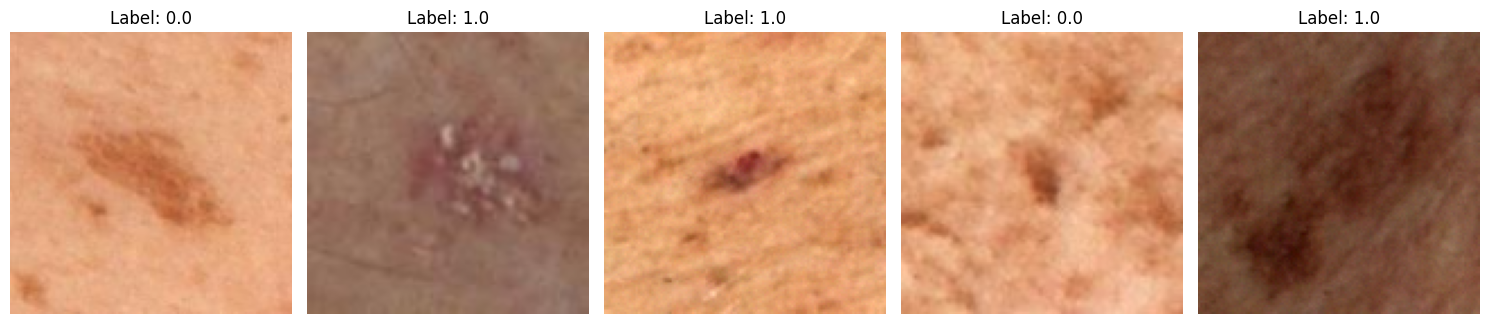

In [11]:

def display_random_images(dataset, num_images=5):
    #Extract a batch of images and labels
    images, labels = next(iter(dataset.shuffle(buffer_size=10000).take(1)))
    
    #Select random indices
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)
    
    #Plot the images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx].numpy()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#Display some random images from the training set
display_random_images(train_images)

---
### CNN Model for Binary Classification

- **Architecture:** `Conv2D` → `MaxPooling2D` → `Conv2D` → `MaxPooling2D` → `Flatten` → `Dense` → `Output`
- **Layers:**
  - 2 `Conv2D`: 32 filters, 3x3 kernel, ReLU
  - 2 `MaxPooling2D`: 2x2 pool
  - 1 `Dense`: 64 units, ReLU
  - 1 `Output`: 1 unit, sigmoid for binary classification
- **Compilation:** Adam optimizer, binary cross-entropy loss, val_accuracy metric
- **Callbacks:** EarlyStopping on `val_accuracy`, ModelCheckpoint for best model


In [ ]:
model = Sequential([
    Conv2D(32,(3,3), strides=(1,1), padding="valid", activation="relu", input_shape=(125, 125, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,(3,3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])


callbacks1=[
        EarlyStopping(monitor='val_accuracy', patience=3),
        ModelCheckpoint('model.keras', save_best_only=True)
    ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['val_accuracy'])

history = model.fit(train_images, epochs=model1_epochs, validation_data=validation_images, verbose=1, callbacks=callbacks1)

Epoch 1/50


C:\Users\neder\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    155/Unknown 17s 67ms/step - accuracy: 0.6526 - loss: 0.6295

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.6528 - loss: 0.6293 - val_accuracy: 0.7151 - val_loss: 0.5969
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.7816 - loss: 0.4736 - val_accuracy: 0.8141 - val_loss: 0.4424
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.8197 - loss: 0.4256 - val_accuracy: 0.8280 - val_loss: 0.4069
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.8219 - loss: 0.4113 - val_accuracy: 0.8274 - val_loss: 0.4262
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.8292 - loss: 0.4164 - val_accuracy: 0.8319 - val_loss: 0.4150
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.8238 - loss: 0.4093 - val_accuracy: 0.8401 - val_loss: 0.3969
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.8431 - loss: 0.3746 - val_accuracy: 0.8103 - val_loss: 0.4112
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.8472 - loss: 0.3583 - val_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

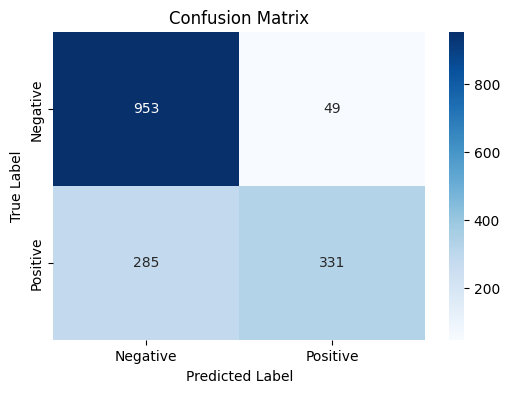

In [15]:
y_true = [] 
y_pred = [] 

#Iterate over the test dataset
for img, label in test_images:
    y_true.extend(label.numpy())
    y_pred.extend((model.predict(img) > 0.5).astype(int).flatten())

#Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

#Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CNN Confusion Matrix")
plt.show()

In [13]:
def predict_images(dataset):
   predictions = []
   
   for img_name in dataset['isic_id']:
       image_path = os.path.join(folder_path, img_name + ".jpg")
       
       if os.path.exists(image_path):
           #Preprocess the image
           img = preprocess_image(img_name)
           img_array = image_to_array(img)
           
           #Make prediction
           prediction = model.predict(img_array)

           #Round predicted value to 3 decimals
           rounded_prediction = round(float(prediction), 3)

           #Round predicted value to 1 or 0
           #predicted_class = 1 if rounded_prediction >= 0.7 else 0
           
           predictions.append(rounded_prediction)
       else:
           predictions.append(None)
           print(f"Image {img_name} not found in {folder_path}.")
   
   #Add predictions as a new column in the dataset
   dataset['model_predictions'] = predictions

print(f"The dataset has {X_metadata.shape[1]} columns.")
predict_images(X_metadata)

#Remove the isic_id collumn from the metadata sheet, as it is no longer neccessary 
X_metadata = X_metadata.drop(columns=["isic_id"])
Y_metadata = Y_metadata.drop(columns=["isic_id"])

In [14]:
#Split main dataset into train and test batches again
#Now with the predictions from the first model included. 
X_train, X_test, Y_train, Y_test = train_test_split(X_metadata, Y_metadata, test_size=0.2, shuffle=True)

#Split training dataset into train and validation batches
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2/0.8)# 0.2/0.8 x 0.8 = 0.2

print("X shape:")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(" ")
print("Y shape:")
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
print(" ")
print("first element:")
print(" ")
print(X_train.iloc[0])
print(" ")
print(Y_train.iloc[0])

The dataset has 44 columns.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\neder\AppData\Local\Temp\ipykernel_32568\1294161869.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded_prediction = round(float(prediction), 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

---
### Dense Neural Network for Binary Classification

- **Architecture:** `Dense` → `Dense` → `Dense` → `Output`
- **Layers:**
  - 3 `Dense`: 256 units, ReLU
  - 1 `Output`: 1 unit, sigmoid for binary classification
- **Compilation:** Adam optimizer, binary cross-entropy loss, accuracy metric
- **Callbacks:** EarlyStopping on `val_accuracy`, ModelCheckpoint for best model


In [ ]:
model2 = Sequential()
model2.add(Dense(units=256, activation='relu', input_shape=(44,)))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

callbacks2=[
        EarlyStopping(monitor='val_accuracy', patience=3),
        ModelCheckpoint('model.keras', save_best_only=True)
    ]


history2 = model2.fit(X_train, Y_train, epochs=model2_epochs, batch_size=32, validation_data=(X_val, Y_val), verbose=1, callbacks=callbacks2)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step


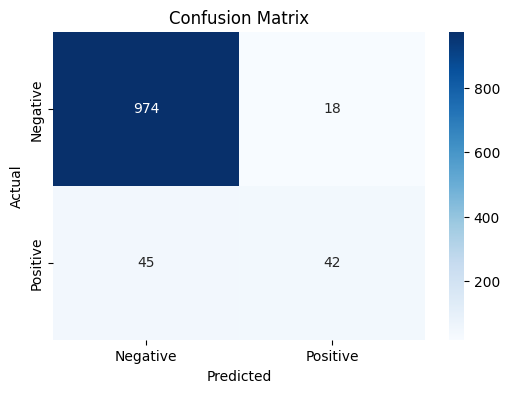

In [31]:
#Get predictions on testing data
Y_pred = model2.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype(int)

#Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)

#Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Dense Confusion Matrix')
plt.show()